<a href="https://colab.research.google.com/github/deepakp23/Tensorflow/blob/main/Transfer_learning_with_tensorflow.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [20]:
!nvidia-smi

Wed Aug 18 11:08:37 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.57.02    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   71C    P0    30W /  70W |   8886MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [21]:
import zipfile

!wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip

zip_ref = zipfile.ZipFile("10_food_classes_10_percent.zip")
zip_ref.extractall()
zip_ref.close()

--2021-08-18 11:08:38--  https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 142.251.2.128, 142.250.141.128, 2607:f8b0:4023:c0b::80, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|142.251.2.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 168546183 (161M) [application/zip]
Saving to: ‘10_food_classes_10_percent.zip.1’

10_food_classes_10_ 100%[===================>] 160.74M  87.7MB/s    in 1.8s    

2021-08-18 11:08:40 (87.7 MB/s) - ‘10_food_classes_10_percent.zip.1’ saved [168546183/168546183]



In [22]:
import os

for dirpath, dirfile, filename in os.walk("10_food_classes_10_percent"):
  print(dirpath, len(dirfile), len(filename))

10_food_classes_10_percent 2 0
10_food_classes_10_percent/train 10 0
10_food_classes_10_percent/train/hamburger 0 75
10_food_classes_10_percent/train/chicken_curry 0 75
10_food_classes_10_percent/train/fried_rice 0 75
10_food_classes_10_percent/train/ice_cream 0 75
10_food_classes_10_percent/train/ramen 0 75
10_food_classes_10_percent/train/steak 0 75
10_food_classes_10_percent/train/sushi 0 75
10_food_classes_10_percent/train/chicken_wings 0 75
10_food_classes_10_percent/train/pizza 0 75
10_food_classes_10_percent/train/grilled_salmon 0 75
10_food_classes_10_percent/test 10 0
10_food_classes_10_percent/test/hamburger 0 250
10_food_classes_10_percent/test/chicken_curry 0 250
10_food_classes_10_percent/test/fried_rice 0 250
10_food_classes_10_percent/test/ice_cream 0 250
10_food_classes_10_percent/test/ramen 0 250
10_food_classes_10_percent/test/steak 0 250
10_food_classes_10_percent/test/sushi 0 250
10_food_classes_10_percent/test/chicken_wings 0 250
10_food_classes_10_percent/test/piz

In [23]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [24]:
IMAGE_SHAPE = (224, 224)
BATCH_SIZE = 32
EPOCHS = 5

train_dir = '10_food_classes_10_percent/train/'
test_dir = '10_food_classes_10_percent/test/'

train_datagen = ImageDataGenerator(rescale = 1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

train_data = train_datagen.flow_from_directory(train_dir,
                                               target_size = IMAGE_SHAPE,
                                               batch_size = BATCH_SIZE,
                                               class_mode='categorical')

test_data = test_datagen.flow_from_directory(test_dir,
                                            target_size = IMAGE_SHAPE,
                                            batch_size = BATCH_SIZE,
                                            class_mode='categorical')

Found 750 images belonging to 10 classes.
Found 2500 images belonging to 10 classes.


In [25]:
## Callbacks
## Track our experiment using tensorboard callback
import datetime
 
def create_tensorboard_callback(dir_name, exp_name):
  log_dir = dir_name + '/' + exp_name + '/' + datetime.datetime.now().strftime('%Y%m%d-%H%M%S')
  tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir)
  print('Saving the Tesorboard log file to {}'.format(log_dir))
  return tensorboard_callback

In [26]:
## Creating models using Tensorflow Hub

resnet_url = 'https://tfhub.dev/google/imagenet/resnet_v2_50/feature_vector/5'
efficientnet_url = 'https://tfhub.dev/tensorflow/efficientnet/b0/feature-vector/1'

In [27]:
import tensorflow as tf
import tensorflow_hub as hub
from tensorflow.keras import layers

In [28]:
def create_model(model_url, num_classes):

  feature_extractor_layer = hub.KerasLayer(model_url,
                                           trainable = False,
                                           name='feature_extraction_layer',
                                           input_shape = IMAGE_SHAPE + (3, )) ## freeze the already learned pattern


  model = tf.keras.models.Sequential([
                  feature_extractor_layer,
                  layers.Dense(num_classes, activation="softmax", name="output_layer")
  ])

  return model

## Creating Resnet model 

In [29]:
resnet_model = create_model(resnet_url,
                            num_classes = train_data.num_classes)

In [30]:
resnet_model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
feature_extraction_layer (Ke (None, 2048)              23564800  
_________________________________________________________________
output_layer (Dense)         (None, 10)                20490     
Total params: 23,585,290
Trainable params: 20,490
Non-trainable params: 23,564,800
_________________________________________________________________


In [31]:
resnet_model.compile(loss='categorical_crossentropy', optimizer=tf.keras.optimizers.Adam(),
                     metrics = ['accuracy'])

In [32]:
history_resnet = resnet_model.fit(train_data,
                 epochs = 5,
                 steps_per_epoch=len(train_data),
                 validation_data = test_data,
                 validation_steps = len(test_data),
                 callbacks = [create_tensorboard_callback("tensorflow_hub","resnet50v2")])

Saving the Tesorboard log file to tensorflow_hub/resnet50v2/20210818-110843
Epoch 1/5
24/24 [==============================] - 21s 761ms/step - loss: 1.8995 - accuracy: 0.3533 - val_loss: 1.2088 - val_accuracy: 0.6200
Epoch 2/5
24/24 [==============================] - 15s 664ms/step - loss: 0.9005 - accuracy: 0.7333 - val_loss: 0.8883 - val_accuracy: 0.7156
Epoch 3/5
24/24 [==============================] - 16s 669ms/step - loss: 0.6191 - accuracy: 0.8280 - val_loss: 0.7713 - val_accuracy: 0.7520
Epoch 4/5
24/24 [==============================] - 15s 662ms/step - loss: 0.4694 - accuracy: 0.8827 - val_loss: 0.7167 - val_accuracy: 0.7664
Epoch 5/5
24/24 [==============================] - 15s 659ms/step - loss: 0.3775 - accuracy: 0.9067 - val_loss: 0.7018 - val_accuracy: 0.7656


In [33]:
import matplotlib.pyplot as plt

def plot_loss_curves(history):
  loss = history.history['loss']
  val_loss = history.history['val_loss']

  accuracy = history.history['accuracy']
  val_accuracy = history.history['val_accuracy']

  epochs = range(len(history.history['loss']))

  plt.plot(epochs, loss, label = 'training loss')
  plt.plot(epochs, val_loss, label = 'validation loss')
  plt.title("Loss")
  plt.xlabel("epochs")
  plt.legend()

  plt.figure()
  plt.plot(epochs, accuracy, label = 'Accuracy')
  plt.plot(epochs, val_accuracy, label = 'validation accuracy')
  plt.title("Accuracy")
  plt.xlabel("epochs")
  plt.legend()  

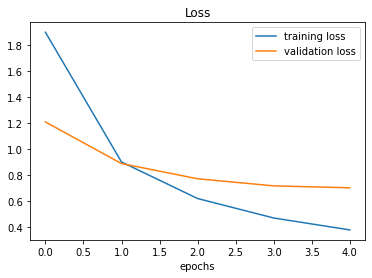

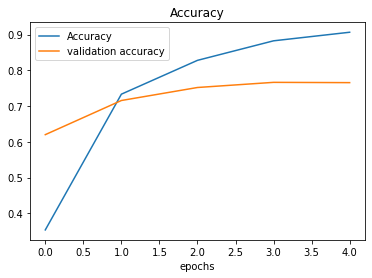

In [34]:
plot_loss_curves(history_resnet)

In [35]:
efficienet_model = create_model(efficientnet_url,
                            num_classes = train_data.num_classes)

In [36]:
efficienet_model.compile(loss='categorical_crossentropy', optimizer=tf.keras.optimizers.Adam(),
                     metrics = ['accuracy'])

In [37]:
history_efficienet = efficienet_model.fit(train_data,
                 epochs = 5,
                 steps_per_epoch=len(train_data),
                 validation_data = test_data,
                 validation_steps = len(test_data),
                 callbacks = [create_tensorboard_callback("tensorflow_hub","efficientnetb0")])

Saving the Tesorboard log file to tensorflow_hub/efficientnetb0/20210818-111017
Epoch 1/5
24/24 [==============================] - 24s 774ms/step - loss: 1.8529 - accuracy: 0.4387 - val_loss: 1.3181 - val_accuracy: 0.7156
Epoch 2/5
24/24 [==============================] - 15s 629ms/step - loss: 1.0611 - accuracy: 0.7813 - val_loss: 0.8788 - val_accuracy: 0.8068
Epoch 3/5
24/24 [==============================] - 15s 624ms/step - loss: 0.7514 - accuracy: 0.8387 - val_loss: 0.7034 - val_accuracy: 0.8364
Epoch 4/5
24/24 [==============================] - 14s 621ms/step - loss: 0.6032 - accuracy: 0.8653 - val_loss: 0.6134 - val_accuracy: 0.8528
Epoch 5/5
24/24 [==============================] - 15s 623ms/step - loss: 0.5110 - accuracy: 0.8880 - val_loss: 0.5574 - val_accuracy: 0.8620


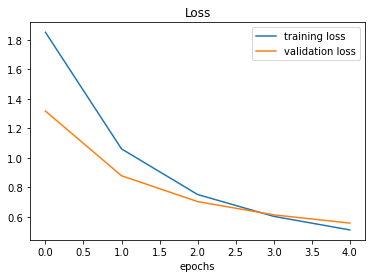

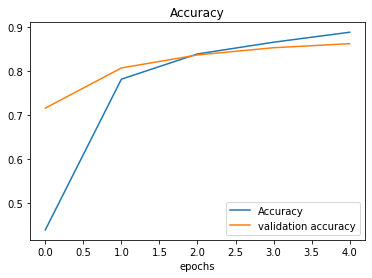

In [38]:
plot_loss_curves(history_efficienet)

## Comparing Model on Tensorboard

In [41]:
!tensorboard dev upload --logdir ./tensorflow_hub/ \
  --name "Efficient net b0 vs Rest net 50 v2" \
  --description "Comparing two pretrained model architecture." \
  --one_shot 

2021-08-18 11:17:15.234361: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-08-18 11:17:15.254410: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-08-18 11:17:15.254865: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero

***** TensorBoard Uploader *****

This will upload your TensorBoard logs to https://tensorboard.dev/ from
the following directory:

./tensorflow_hub/

This TensorBoard will be visible to everyone. Do not upload sensitive
data.

Your use of this service is subject to Google's Terms of Service
<https://policies.google.com/terms> and Privac

In [ ]:
yes